# Startup Investment Trend Analyzer
End-to-end analysis and prediction using startup funding data.

## Dataset
- Use [Startup Funding Dataset from Kaggle](https://www.kaggle.com/datasets/ruchi798/startup-investments)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

## Loading dataset

In [2]:
# Load and preprocess data
df = pd.read_csv("indian_startup_funding.csv")

In [3]:
df.head()

,Date,Startup Name,Industry,Sub-vertical,Location,Investors,Investment Type,Amount in USD,Website URL
0,2021-04-14,Swiggy,Online Food Delivery,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,https://www.swiggy.com/
1,2021-04-14,Beldara,E-commerce,Global B2B marketplace,Mumbai,Hindustan Media Ventures,Venture,7400000.0,https://beldara.com/
2,2021-04-07,Groww,FinTech,Investment platform,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,https://groww.in/
3,2021-04-05,Meesho,E-commerce,Online reselling platform,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,http://www.meesho.com/
4,2021-04-01,BYJU’S,Edu-tech,Online tutoring,Bengaluru,Innoven Capital,Series F,460000000.0,http://www.byjus.com/


In [4]:
# Select relevant columns and rename columns
df = df[['Date', 'Startup Name', 'Industry', 'Location', 'Investment Type', 'Amount in USD']]
df = df.rename(columns={
    'Date': 'date',
    'Startup Name': 'startup_name',
    'Industry': 'industry',
    'Location': 'location',
    'Investment Type': 'investment_type',
    'Amount in USD': 'funding_amount'
})


In [5]:
df.head()

,date,startup_name,industry,location,investment_type,funding_amount
0,2021-04-14,Swiggy,Online Food Delivery,Bengaluru,Series J,343000000.0
1,2021-04-14,Beldara,E-commerce,Mumbai,Venture,7400000.0
2,2021-04-07,Groww,FinTech,Bengaluru,Series D,83000000.0
3,2021-04-05,Meesho,E-commerce,Bengaluru,Series E,300000000.0
4,2021-04-01,BYJU’S,Edu-tech,Bengaluru,Series F,460000000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             3210 non-null   object 
 1   startup_name     3212 non-null   object 
 2   industry         2276 non-null   object 
 3   location         3032 non-null   object 
 4   investment_type  3205 non-null   object 
 5   funding_amount   2222 non-null   float64
dtypes: float64(1), object(5)
memory usage: 150.7+ KB


##   Data Analysis

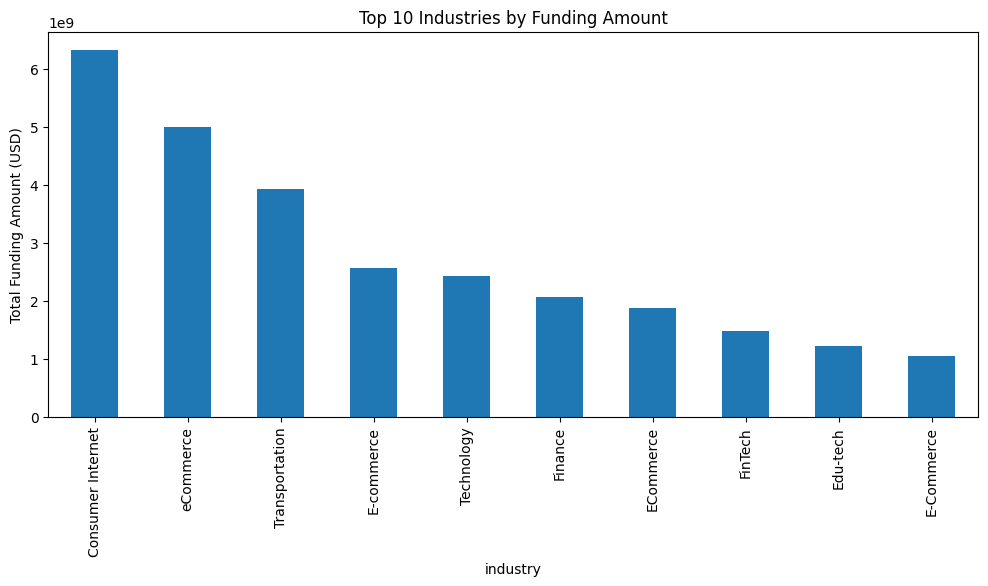

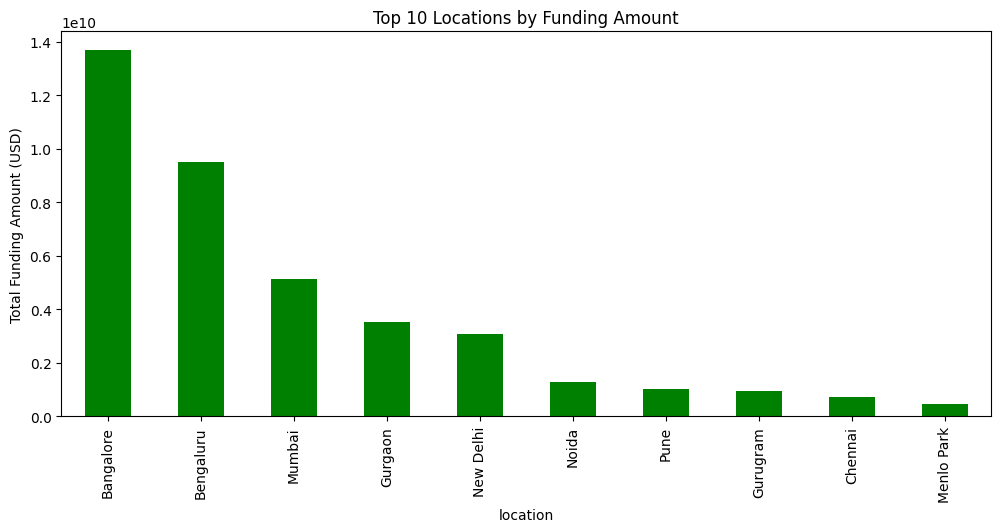

In [7]:
top_industries = df.groupby('industry')['funding_amount'].sum().sort_values(ascending=False).head(10)
top_locations = df.groupby('location')['funding_amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
top_industries.plot(kind='bar')
plt.title('Top 10 Industries by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

plt.figure(figsize=(12,5))
top_locations.plot(kind='bar', color='green')
plt.title('Top 10 Locations by Funding Amount')
plt.ylabel('Total Funding Amount (USD)')
plt.show()

## cleaning and handling missing value

In [8]:
# Clean funding amount
df['funding_amount'] = df['funding_amount'].astype(str).str.replace(',', '').str.strip()
df['funding_amount'] = pd.to_numeric(df['funding_amount'], errors='coerce')


In [9]:
# Parse date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Fill missing funding_amount with median
df['funding_amount'] = df['funding_amount'].fillna(df['funding_amount'].median())

In [10]:
# Handle missing categorical data by filling with 'Unknown'
categorical_cols = ['industry', 'location', 'investment_type']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [11]:
# Drop rows with missing date (if any)
df.dropna(subset=['date'], inplace=True)

## Add date features

In [12]:
# Add date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


## Handle outliers

In [13]:
# Handle outliers using IQR (Interquartile Range)
Q1 = df['funding_amount'].quantile(0.25)
Q3 = df['funding_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Remove outliers
df = df[(df['funding_amount'] >= lower_bound) & (df['funding_amount'] <= upper_bound)]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2731 entries, 1 to 3209
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2731 non-null   datetime64[ns]
 1   startup_name     2731 non-null   object        
 2   industry         2731 non-null   object        
 3   location         2731 non-null   object        
 4   investment_type  2731 non-null   object        
 5   funding_amount   2731 non-null   float64       
 6   year             2731 non-null   int32         
 7   month            2731 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 170.7+ KB


## Predicting the Funding Amount

In [15]:
# Log-transform the target variable
df['log_funding'] = np.log1p(df['funding_amount'])


In [16]:
# Features and target
features = df[['industry', 'location', 'investment_type', 'year', 'month']]
target = df['log_funding']

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [18]:
# Preprocessor for categorical features
categorical_features = ['industry', 'location', 'investment_type']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough',force_int_remainder_cols=False   # keep 'year' and 'month' as it is
)

In [19]:
# Model pipeline using XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42))
])

In [20]:
# Train model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['industry', 'location',
                                                   'investment_type'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, de...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [21]:
# Predict and reverse log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

## Evaluation

In [22]:
# Evaluate

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
-scores.mean()

np.float64(1.0975625252465722)

In [23]:
rmse_scores=np.sqrt(-scores)
rmse_scores

array([1.0285758 , 1.05522057, 1.01972969, 1.0459976 , 1.0873796 ])

In [24]:
def print_scores(scores):
    print("scores",scores)
    print("mean",scores.mean())
    print("standard deviation",scores.std())

In [25]:
print_scores(rmse_scores)

scores [1.0285758  1.05522057 1.01972969 1.0459976  1.0873796 ]
mean 1.04738065050686
standard deviation 0.023585974442438977


## Saving the model

In [26]:
import numpy as np
from joblib import dump, load

In [27]:
dump(model, 'startup_pred.joblib')
print("Model saved to 'startup_pred.joblib'")

Model saved to 'startup_pred.joblib'


## Testing the model on test dataset

In [28]:
from joblib import dump,load
model=load('startup_pred.joblib')

In [29]:
y_test.head()

# Convert back to original scale (USD)
y_t= np.expm1(y_test)
y_t.head()

1269    2000000.0
2389     100000.0
1809     500000.0
1206    2000000.0
123     4000000.0
Name: log_funding, dtype: float64

In [30]:
X_test.head()

,industry,location,investment_type,year,month
1269,Technology,Bangalore,Private Equity,2016,12
2389,Unknown,Bangalore,Seed Funding,2015,11
1809,eCommerce,Mumbai,Seed Funding,2016,6
1206,Technology,Bangalore,Seed Funding,2017,1
123,E-commerce,Bengaluru,Debt Financing,2020,3


In [33]:
input= pd.DataFrame([
    {
        "industry": "eCommerce",
        "location": "Mumbai",
        "investment_type": "Seed Funding",
        "year": 2016,
        "month": 6
    }
])

In [34]:
# Predict log_funding
log_preds = model.predict(input)

# Convert back to original scale (USD)
predictions = np.expm1(log_preds)
predictions[0]

np.float32(709892.94)